In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [19]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train = datasets.MNIST('../data/MNIST/train', train=True, download=True, transform=mnist_transform)
test = datasets.MNIST('../data/MNIST/test', train=False, download=True, transform=mnist_transform)

trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [29]:
class Net_1l(nn.Module):
    
    class Encoder(nn.Module):
        def __init__(self, activation=F.sigmoid, init_fn = lambda _: None, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(28*28, latent_size)
            init_fn(self.fc1.weight)            
            self.activation = activation

        def forward(self, x):
            x = self.activation(self.fc1(x))
            return x

    class Decoder(nn.Module):
        def __init__(self, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(latent_size, 28*28)
            nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, x):
            x = torch.tanh(self.fc1(x))
            return x
    
    def __init__(self, activation=F.sigmoid, init_fn = lambda _: None, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.latent_size = latent_size
        self.E = self.Encoder(activation=activation, init_fn=init_fn, latent_size=latent_size)
        self.D = self.Decoder(latent_size=latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x.cuda(), target.cuda(), **kwargs)
        return self._loss

In [30]:
class Net_2l(nn.Module):
    
    class Encoder(nn.Module):
        def __init__(self, activation=F.sigmoid, init_fn = lambda _: None, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(28*28, latent_size*2)
            init_fn(self.fc1.weight)
            self.fc2 = nn.Linear(latent_size*2, latent_size)
            init_fn(self.fc2.weight)

            self.activation = activation

        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            return x
    
    class Decoder(nn.Module):
        def __init__(self, activation=F.sigmoid, init_fn = lambda _: None, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(latent_size, latent_size*2)
            init_fn(self.fc1.weight)
            self.fc2 = nn.Linear(latent_size*2, 28*28)
            nn.init.xavier_uniform_(self.fc2.weight)

            self.activation = activation

        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = F.tanh(self.fc2(x))
            return x
    
    def __init__(self, activation=F.sigmoid, init_fn = lambda _: None, latent_size=10, loss=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.latent_size = latent_size
        self.E = self.Encoder(activation=activation, init_fn=init_fn, latent_size=latent_size)
        self.D = self.Decoder(activation=activation, init_fn=init_fn, latent_size=latent_size)
        self.loss_fn = loss
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
        
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [33]:
models = [
    Net_1l(activation=F.sigmoid, latent_size=64).cuda(),
    Net_1l(activation=F.sigmoid, init_fn=nn.init.xavier_uniform_, latent_size=64).cuda(),
    Net_1l(activation=F.relu, latent_size=64).cuda(),
    Net_1l(activation=F.relu, init_fn=nn.init.kaiming_uniform_, latent_size=64).cuda(),
    Net_2l(activation=F.sigmoid, latent_size=64).cuda(),
    Net_2l(activation=F.sigmoid, init_fn=nn.init.xavier_uniform_, latent_size=64).cuda(),
    Net_2l(activation=F.relu, latent_size=64).cuda(),
    Net_2l(activation=F.relu, init_fn=nn.init.kaiming_uniform_, latent_size=64).cuda()
]
loss_test = []
epochs = 100
i = 0
loss__ = []

for e in range(epochs):
    loss_ = []
    for model in models:
        for data, _ in trainset:
            model.optim.zero_grad()
            output = model(data.cuda())
            loss = model.loss(data.view(-1, 28*28).cuda(), output.cuda())
            loss.backward()
            model.optim.step()

        for test_data, _ in testset:
            with torch.no_grad():
                output = model(test_data.cuda())
                loss = model.loss(test_data.view(-1, 28*28).cuda(), output.cuda())
        else:
            loss_.append(loss)
      
    loss__.append(loss_)
    print("epoch %d. Losses: %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f" % (e+1, *loss_))

epoch 1. Losses: 0.275 0.301 0.168 0.182 0.279 0.254 0.189 0.140
epoch 2. Losses: 0.236 0.219 0.092 0.095 0.259 0.249 0.123 0.114
epoch 3. Losses: 0.213 0.194 0.084 0.086 0.269 0.270 0.099 0.114
epoch 4. Losses: 0.197 0.184 0.054 0.056 0.250 0.235 0.077 0.069
epoch 5. Losses: 0.159 0.145 0.054 0.051 0.249 0.176 0.069 0.076
epoch 6. Losses: 0.145 0.140 0.045 0.056 0.234 0.195 0.049 0.056
epoch 7. Losses: 0.127 0.123 0.048 0.045 0.209 0.166 0.048 0.048
epoch 8. Losses: 0.133 0.121 0.043 0.042 0.205 0.167 0.048 0.070
epoch 9. Losses: 0.106 0.102 0.038 0.038 0.177 0.157 0.057 0.055
epoch 10. Losses: 0.100 0.101 0.029 0.031 0.201 0.149 0.041 0.048
epoch 11. Losses: 0.099 0.100 0.040 0.037 0.171 0.129 0.044 0.055
epoch 12. Losses: 0.089 0.080 0.037 0.028 0.181 0.174 0.032 0.045
epoch 13. Losses: 0.084 0.076 0.030 0.027 0.154 0.142 0.032 0.051
epoch 14. Losses: 0.071 0.091 0.027 0.030 0.136 0.120 0.031 0.056
epoch 15. Losses: 0.069 0.084 0.022 0.025 0.144 0.146 0.034 0.048
epoch 16. Losses: 0

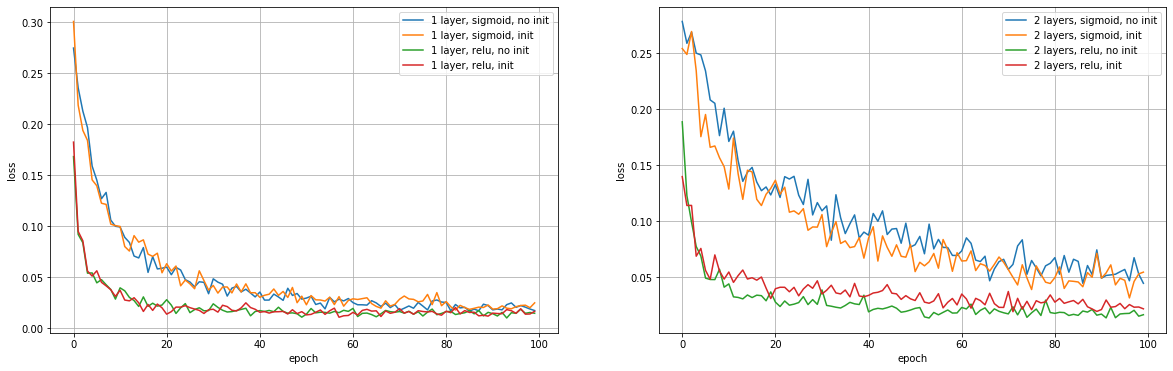

In [68]:
f = plt.figure(figsize=(20, 6))

ax0 = f.add_subplot(121)
plt.plot(np.array(loss__)[:, 0], label='1 layer, sigmoid, no init')
plt.plot(np.array(loss__)[:, 1], label='1 layer, sigmoid, init')
plt.plot(np.array(loss__)[:, 2], label='1 layer, relu, no init')
plt.plot(np.array(loss__)[:, 3], label='1 layer, relu, init')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

ax0 = f.add_subplot(122)
plt.plot(np.array(loss__)[:, 4], label='2 layers, sigmoid, no init')
plt.plot(np.array(loss__)[:, 5], label='2 layers, sigmoid, init')
plt.plot(np.array(loss__)[:, 6], label='2 layers, relu, no init')
plt.plot(np.array(loss__)[:, 7], label='2 layers, relu, init')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [80]:
loss__[-1]

[tensor(0.0175, device='cuda:0'),
 tensor(0.0250, device='cuda:0'),
 tensor(0.0148, device='cuda:0'),
 tensor(0.0167, device='cuda:0'),
 tensor(0.0445, device='cuda:0'),
 tensor(0.0545, device='cuda:0'),
 tensor(0.0164, device='cuda:0'),
 tensor(0.0217, device='cuda:0')]

In [76]:
data, labels = next(iter(testset))

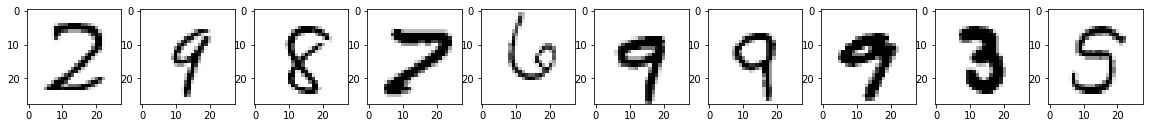

In [77]:
f = plt.figure(figsize=(20, 32))
ncols = 10

for i, img in enumerate(data[:10]):
    ax = f.add_subplot(np.ceil(len(data)/ncols), ncols, i+1)
    plt.imshow(img.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)

In [81]:
data = models[-3](data.cuda()).cpu().view(-1, 1, 28, 28)

D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


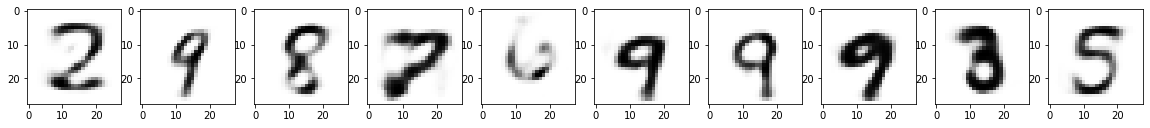

In [82]:
f = plt.figure(figsize=(20, 32))
ncols = 10

for i, img in enumerate(data[:10]):
    ax = f.add_subplot(np.ceil(len(data)/ncols), ncols, i+1)
    plt.imshow(img.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)